WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


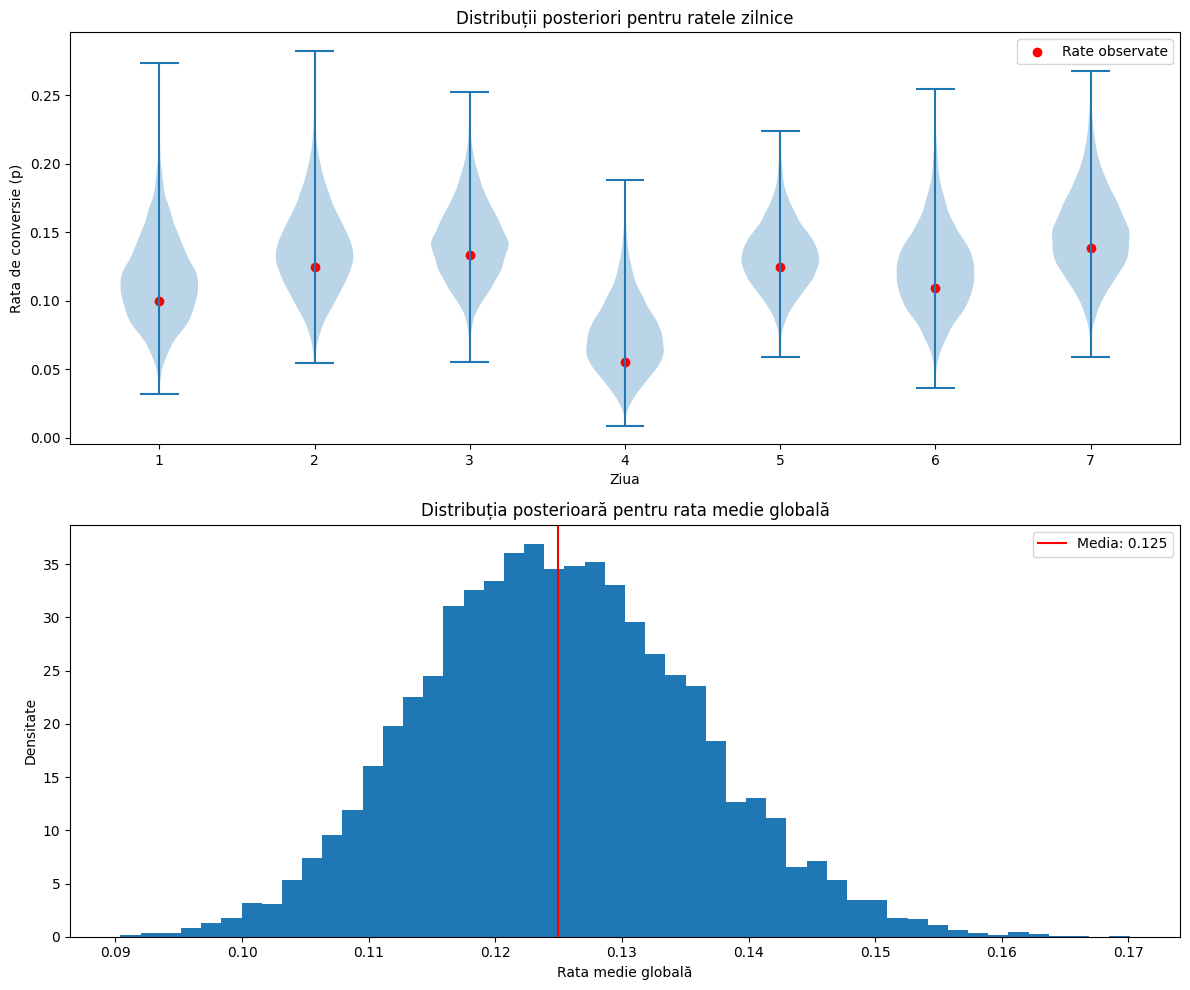

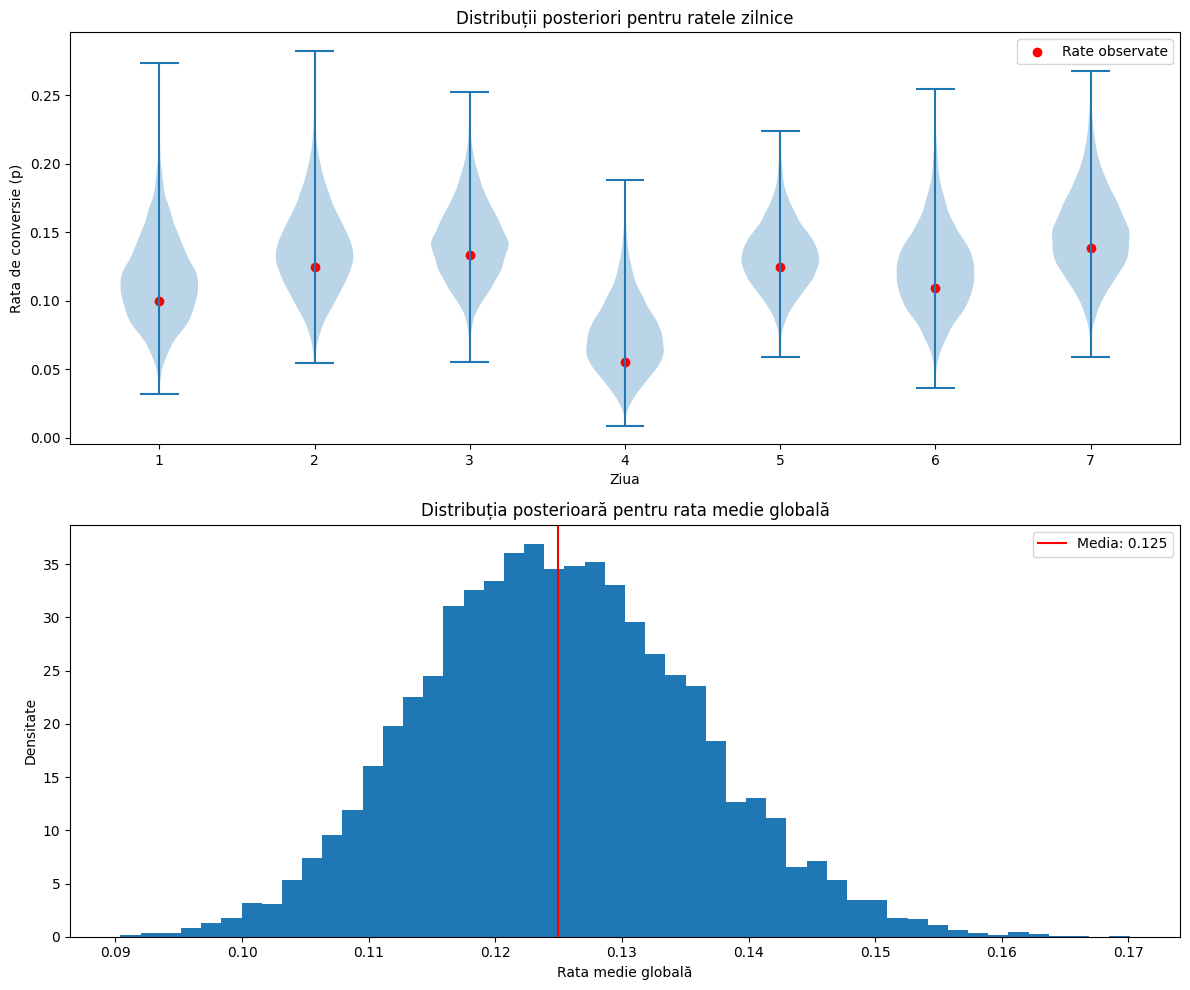

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

k_obs = np.array([10, 15, 20, 5, 25, 12, 18])
n_obs = np.array([100, 120, 150, 90, 200, 110, 130])
days = np.arange(1,8)

with pm.Model() as our_first_model:
    # a priori
    p = pm.Beta('p', alpha=2, beta=2, shape=7)
    
    # media ratelor
    p_mean = pm.Deterministic("p_mean", p.mean())
    
    # likelihood
    k = pm.Binomial("k", n=n_obs, p=p, observed=k_obs)
    
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)
    
az.summary(trace, var_names=["p", "p_mean"])

    
def plot_results(trace):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot pentru ratele zilnice
    p_samples = trace.posterior["p"].values.reshape(-1, 7)
    violin_parts = ax1.violinplot([p_samples[:, i] for i in range(7)], 
                                positions=days)
    
    # Adăugăm ratele observate
    ax1.scatter(days, k_obs/n_obs, color='red', label='Rate observate')
    ax1.set_xlabel('Ziua')
    ax1.set_ylabel('Rata de conversie (p)')
    ax1.set_title('Distribuții posteriori pentru ratele zilnice')
    ax1.legend()
    
    # Plot pentru rata medie
    p_mean_samples = trace.posterior["p_mean"].values.flatten()
    ax2.hist(p_mean_samples, bins=50, density=True)
    ax2.axvline(np.mean(p_mean_samples), color='red', 
                label=f'Media: {np.mean(p_mean_samples):.3f}')
    ax2.set_xlabel('Rata medie globală')
    ax2.set_ylabel('Densitate')
    ax2.set_title('Distribuția posterioară pentru rata medie globală')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Generăm și afișăm graficele
plot_results(trace)



In [3]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# Read and prepare the data
def prepare_data(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Convert minute to hour fraction (starting from 4:00)
    df['hour'] = 4 + df['minut'] / 60
    
    return df

def create_model(data):
    with pm.Model() as model:
        # Prior for changepoint locations around known approximate times
        # We'll use normal distributions centered around the approximate times
        cp1 = pm.Normal('cp1', mu=7, sigma=0.5)  # Around 7:00
        cp2 = pm.Normal('cp2', mu=8, sigma=0.5)  # Around 8:00
        cp3 = pm.Normal('cp3', mu=16, sigma=0.5) # Around 16:00
        cp4 = pm.Normal('cp4', mu=19, sigma=0.5) # Around 19:00
        
        # Priors for lambda parameters in each interval
        # Using positive normal distributions
        lambda1 = pm.HalfNormal('lambda1', sigma=20)  # Prior for 4:00 - cp1
        lambda2 = pm.HalfNormal('lambda2', sigma=20)  # Prior for cp1 - cp2
        lambda3 = pm.HalfNormal('lambda3', sigma=20)  # Prior for cp2 - cp3
        lambda4 = pm.HalfNormal('lambda4', sigma=20)  # Prior for cp3 - cp4
        lambda5 = pm.HalfNormal('lambda5', sigma=20)  # Prior for cp4 - 24:00
        
        # Calculate lambda for each time point
        hour = data['hour'].values
        lambda_t = pm.math.switch(hour < cp1, lambda1,
                     pm.math.switch(hour < cp2, lambda2,
                         pm.math.switch(hour < cp3, lambda3,
                             pm.math.switch(hour < cp4, lambda4, lambda5))))
        
        # Likelihood (Poisson)
        y = pm.Poisson('y', mu=lambda_t, observed=data['nr. masini'])
        
        # Sampling
        trace = pm.sample(2000, tune=1000, return_inferencedata=True)
        
    return model, trace

def analyze_results(trace):
    # Get mean values for changepoints and lambdas
    summary = az.summary(trace)
    
    changepoints = [
        summary.loc['cp1', 'mean'],
        summary.loc['cp2', 'mean'],
        summary.loc['cp3', 'mean'],
        summary.loc['cp4', 'mean']
    ]
    
    lambdas = [
        summary.loc['lambda1', 'mean'],
        summary.loc['lambda2', 'mean'],
        summary.loc['lambda3', 'mean'],
        summary.loc['lambda4', 'mean'],
        summary.loc['lambda5', 'mean']
    ]
    
    return changepoints, lambdas

# Load and prepare data
df = prepare_data('trafic.csv')

# Create and run model
model, trace = create_model(df)

# Analyze results
changepoints, lambdas = analyze_results(trace)

# Print results
print("\nMost probable changepoint times (hours):")
for i, cp in enumerate(changepoints, 1):
    print(f"Changepoint {i}: {cp:.2f}")

print("\nMost probable lambda values for each interval:")
for i, lam in enumerate(lambdas, 1):
    print(f"Lambda {i}: {lam:.2f}")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cp1, cp2, cp3, cp4, lambda1, lambda2, lambda3, lambda4, lambda5]


Output()

ValueError: Not enough samples to build a trace.

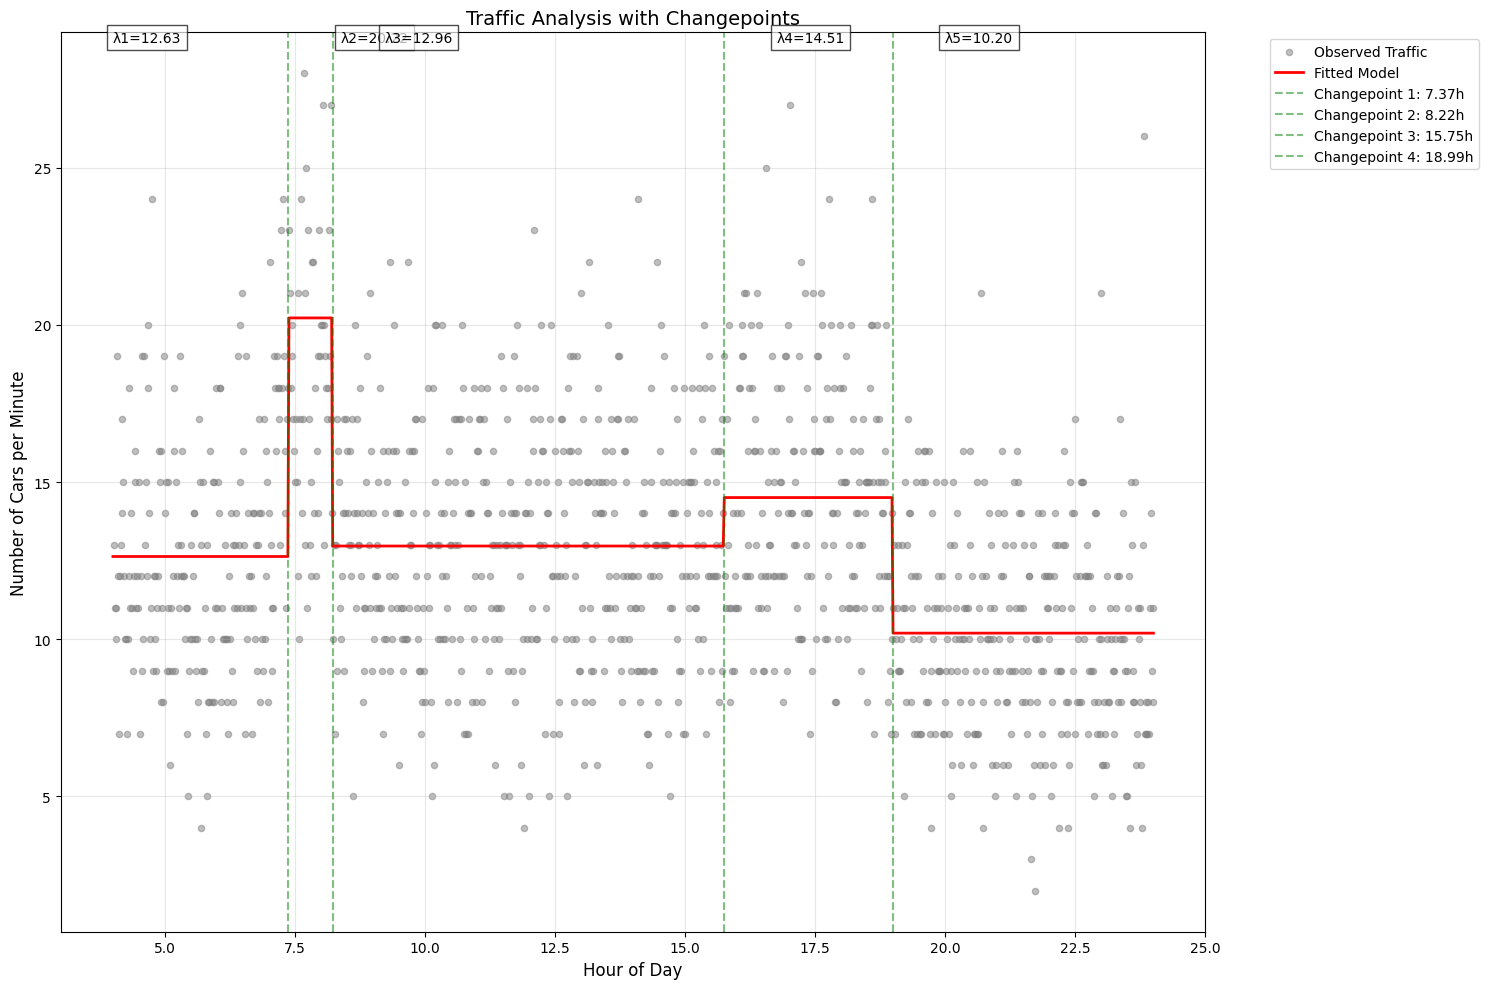

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(df, trace):
    # Get summary statistics
    summary = az.summary(trace)
    
    # Extract changepoints and lambdas
    changepoints = [
        summary.loc['cp1', 'mean'],
        summary.loc['cp2', 'mean'],
        summary.loc['cp3', 'mean'],
        summary.loc['cp4', 'mean']
    ]
    
    lambdas = [
        summary.loc['lambda1', 'mean'],
        summary.loc['lambda2', 'mean'],
        summary.loc['lambda3', 'mean'],
        summary.loc['lambda4', 'mean'],
        summary.loc['lambda5', 'mean']
    ]
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot original data
    plt.scatter(df['hour'], df['nr. masini'], alpha=0.5, label='Observed Traffic', 
                color='gray', s=20)
    
    # Plot fitted model
    hours = np.linspace(4, 24, 1000)
    fitted_values = np.zeros_like(hours)
    
    # Fill fitted values based on changepoints
    for i in range(len(hours)):
        if hours[i] < changepoints[0]:
            fitted_values[i] = lambdas[0]
        elif hours[i] < changepoints[1]:
            fitted_values[i] = lambdas[1]
        elif hours[i] < changepoints[2]:
            fitted_values[i] = lambdas[2]
        elif hours[i] < changepoints[3]:
            fitted_values[i] = lambdas[3]
        else:
            fitted_values[i] = lambdas[4]
    
    plt.plot(hours, fitted_values, 'r-', linewidth=2, label='Fitted Model')
    
    # Plot changepoints
    for i, cp in enumerate(changepoints):
        plt.axvline(x=cp, color='g', linestyle='--', alpha=0.5,
                   label=f'Changepoint {i+1}: {cp:.2f}h')
    
    # Customize plot
    plt.title('Traffic Analysis with Changepoints', fontsize=14)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Number of Cars per Minute', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add lambda values annotation
    for i, lam in enumerate(lambdas):
        if i == 0:
            x = 4
        elif i == len(lambdas) - 1:
            x = changepoints[-1] + 1
        else:
            x = changepoints[i-1] + 1
        plt.text(x, max(df['nr. masini']) + 1, f'λ{i+1}={lam:.2f}', 
                bbox=dict(facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
plot_results(df, trace)